In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.0003
UP_COEF = 0.01
GAMMA = 0.99
EPS = 1e-8
GRAD_NORM = True

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )

        self.val = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    # double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        done_mask = 1 - d.detach().to(device).float()
        
        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            _q_best_tgt = _q_batch_tgt[range(BATCH_SIZE), _a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA * done_mask* _q_best_tgt) - q_acting).pow(2).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        if GRAD_NORM:
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q, dim=1)

    return action.item()

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.01
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
env.spec.max_episode_steps

1000

In [7]:
env.spec.trials

100

In [8]:
env.spec.reward_threshold

200

In [9]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_dddqn.pt')
                break
env.close()

  1 Episode in   100 steps, reward -258.17
  2 Episode in   419 steps, reward -2099.21
  3 Episode in   499 steps, reward -202.48
  4 Episode in   627 steps, reward -541.92
  5 Episode in   706 steps, reward -595.52
  6 Episode in   806 steps, reward -464.49
  7 Episode in   884 steps, reward -454.28
  8 Episode in   999 steps, reward -488.70
  9 Episode in  1106 steps, reward -350.72
 10 Episode in  1382 steps, reward -1963.52
 11 Episode in  1464 steps, reward -518.48

============  Start Learning  ============

 12 Episode in  1621 steps, reward -240.98
 13 Episode in  1753 steps, reward -296.33
 14 Episode in  1910 steps, reward -242.30
 15 Episode in  2002 steps, reward -141.55
 16 Episode in  2169 steps, reward -77.79
 17 Episode in  2253 steps, reward -191.24
 18 Episode in  2367 steps, reward -84.37
 19 Episode in  2458 steps, reward -146.50
 20 Episode in  2634 steps, reward -13.20
 21 Episode in  2715 steps, reward -302.75
 22 Episode in  2790 steps, reward -279.75
 23 Episod

193 Episode in 97889 steps, reward -23.27
194 Episode in 98061 steps, reward -26.44
195 Episode in 98180 steps, reward -18.01
196 Episode in 98340 steps, reward -46.19
197 Episode in 98448 steps, reward -61.46
198 Episode in 98604 steps, reward 19.81
199 Episode in 98696 steps, reward -108.45
200 Episode in 99215 steps, reward -237.82
201 Episode in 100215 steps, reward 0.15
202 Episode in 101215 steps, reward 11.79
203 Episode in 101953 steps, reward 177.76
204 Episode in 102060 steps, reward -55.81
205 Episode in 103060 steps, reward 111.26
206 Episode in 103205 steps, reward -23.86
207 Episode in 103431 steps, reward -207.73
208 Episode in 104091 steps, reward 215.24
209 Episode in 105091 steps, reward 100.47
210 Episode in 105465 steps, reward -258.75
211 Episode in 105767 steps, reward 229.50
212 Episode in 106524 steps, reward 168.53
213 Episode in 107299 steps, reward 225.42
214 Episode in 107616 steps, reward 256.35
215 Episode in 108616 steps, reward -26.14
216 Episode in 1091

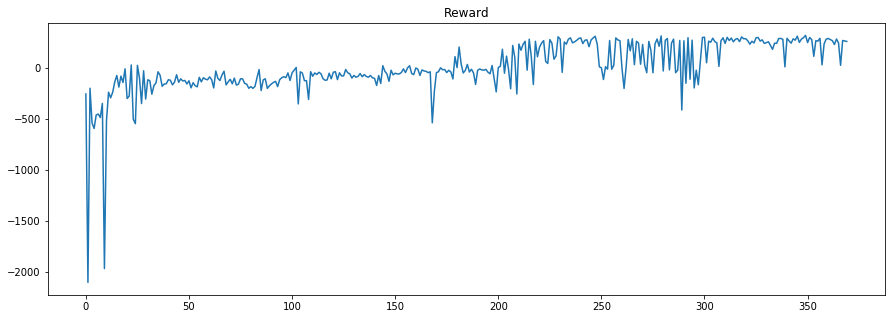

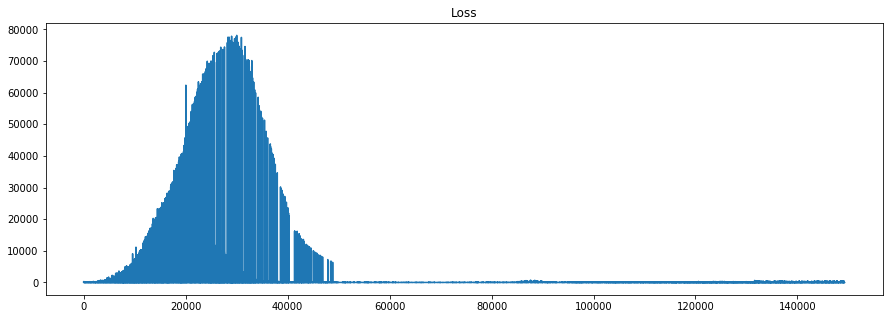

In [10]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [11]:
[
    ('CartPole-v0', 390, 0.25),
    ('CartPole-v1', 346, 0.25),
    ('MountainCar-v0', 810, 0.25),
    ('LunarLander-v2', 370, 0.25)
]

[('CartPole-v0', 390, 0.25),
 ('CartPole-v1', 346, 0.25),
 ('MountainCar-v0', 810, 0.25),
 ('LunarLander-v2', 260, 0.25)]